In [1]:
# check kernel environment
import sys
print("Kernel: {}".format(sys.executable))

# Core data analysis packages
import pandas as pd
import numpy as np

# For our EDA charts
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Compressed Sparse Row matrix
from scipy.sparse import csr_matrix 

# use K-Nearest Neighbors to find cosine distance amongst artists
from sklearn.neighbors import NearestNeighbors

# evaluate a variety of recommender system models in the TuriCreate package
import turicreate as tc

# fuzzy string matching to allow for differing spelling of artist names
from fuzzywuzzy import fuzz, process

# set output to three decimals
pd.set_option('display.float_format',lambda x: '%.2f' %x)

# set seed for reproducibility of random number initializations
seed = np.random.RandomState(seed=42)

Kernel: /usr/bin/python3


In [2]:
# datasets
plays = pd.read_csv('user_artists.dat',sep='\t')
artists = pd.read_csv('artists.dat',sep='\t',usecols=['id','name'])
tags = pd.read_csv('tags.dat', sep='\t',encoding='latin-1')
uta = pd.read_csv('user_taggedartists.dat', sep='\t')
utat = pd.read_csv('user_taggedartists-timestamps.dat', sep="\t")
friends = pd.read_csv('user_friends.dat', sep='\t')

In [3]:
# create a function to provide various statistics on our data files
def print_info(df_list, df_name):
    
    # assertion to ensure our two lists are equal in length
    assert len(df_list) == len(df_name)

    for i in range(len(df_list)):
        print(df_name[i],'\n')
        print("Shape: {}\n".format(df_list[i].shape))
        print("Info:")
        print(df_list[i].info(),'\n')
        print("Unique:\n{}\n".format(df_list[i].nunique()))     
        
        # This returns True if no duplicates are dropped 
        print("No duplicates: {}\n".format(len(df_list[i])==len(df_list[i].drop_duplicates())))

In [4]:
df_list = [plays, artists, tags, uta, utat, friends]
df_name = ['**Plays**',
           '**Artists**',
           '**Tags**',
           '**User Tagged Artists (Date)**',
           '**User Tagged Artists (Timestamp)**',
           '**Friends**']

print_info(df_list,df_name)

**Plays** 

Shape: (92834, 3)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
userID      92834 non-null int64
artistID    92834 non-null int64
weight      92834 non-null int64
dtypes: int64(3)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
weight       5436
dtype: int64

No duplicates: True

**Artists** 

Shape: (17632, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 2 columns):
id      17632 non-null int64
name    17632 non-null object
dtypes: int64(1), object(1)
memory usage: 275.6+ KB
None 

Unique:
id      17632
name    17632
dtype: int64

No duplicates: True

**Tags** 

Shape: (11946, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
tagID       11946 non-null int64
tagValue    11946 non-null object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB
None 

Unique:


In [5]:
ap = pd.merge(artists, 
                plays, 
                how='inner',
                left_on='id',
                right_on='artistID')

ap = ap.rename(columns={"weight":"userArtistPlays"})

ap.head()

,id,name,userID,artistID,userArtistPlays
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [6]:
artist_rank = (ap.groupby(['name']).agg({'userID':'count','userArtistPlays':'sum'}).
    rename(columns={"userID":'totalUniqueUsers',"userArtistPlays":"totalArtistPlays"}).
              sort_values(['totalArtistPlays'],ascending=False))
artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays']/artist_rank['totalUniqueUsers']
user_rank = (ap.groupby(['userID']).agg({'name':'count','userArtistPlays':'sum'}).
    rename(columns={"name":'totalUniqueArtists',"userArtistPlays":"totalUserPlays"}).
            sort_values(['totalUserPlays'],ascending=False))

In [7]:
artist_rank.head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.56
Depeche Mode,282,1301308,4614.57
Lady Gaga,611,1291387,2113.56
Christina Aguilera,407,1058405,2600.50
Paramore,399,963449,2414.66


In [8]:
ap2 = ap.join(artist_rank,on='name',how='inner')
ap3 = ap2.join(user_rank,on='userID',how='inner').sort_values(['userArtistPlays'],ascending=False)

# confirm no duplicated rows
assert ap3[ap3.duplicated(['userID','name'])].empty

In [9]:
ap3.head()

,id,name,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.57,50,388251
35843,792,Thalía,2071,792,324663,26,350035,13462.88,50,338400
27302,511,U2,1094,511,320725,185,493024,2664.99,50,379125
8152,203,Blur,1905,203,257978,114,318221,2791.41,50,276295
26670,498,Paramore,1664,498,227829,399,963449,2414.66,50,251560


In [10]:
print("{:,}".format(ap3['userArtistPlays'].sum()))

69,183,975


In [11]:
# our standard bar chart in a function below

def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x[:20], y[:20], palette="PuRd")
    ax.set_xlabel(x_label,fontweight='bold')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.set_title(title,fontweight='bold')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black') 

    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption, style='italic',fontsize=12,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()   

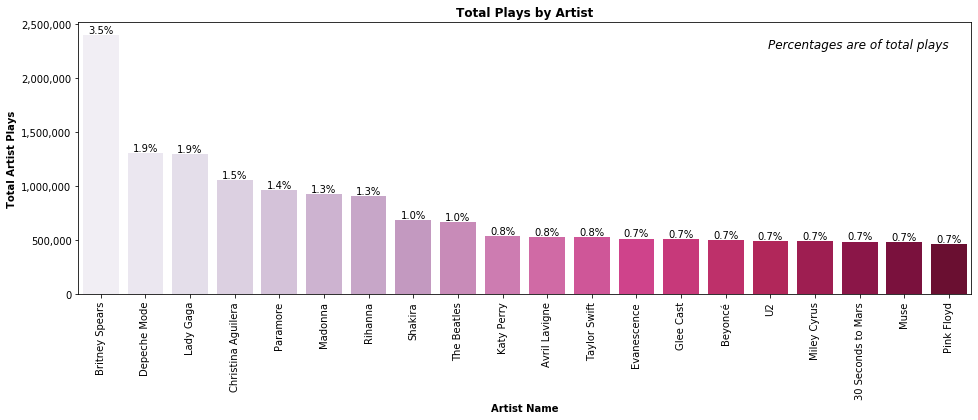

In [12]:
c1 = artist_rank
x = c1.index
y = c1.totalArtistPlays
x_label = 'Artist Name'
y_label = 'Total Artist Plays'
title = 'Total Plays by Artist'
caption = 'Percentages are of total plays'
total_val = c1.totalArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [13]:
artist_rank.sort_values(['totalUniqueUsers'],ascending=False).head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Lady Gaga,611,1291387,2113.56
Britney Spears,522,2393140,4584.56
Rihanna,484,905423,1870.71
The Beatles,480,662116,1379.41
Katy Perry,473,532545,1125.89


In [14]:
len(ap3['userArtistPlays'][ap3['name']=='Lady Gaga'])

611

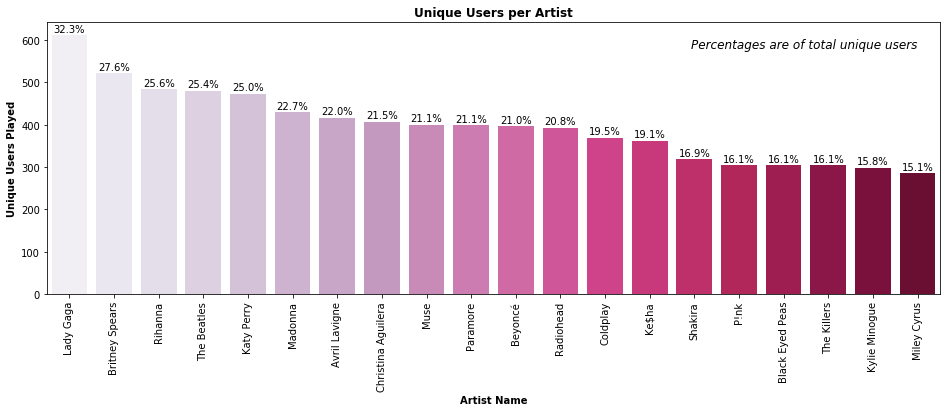

In [15]:
# Lady Gaga has been played by 32.3% of the users in the sample
c2 = artist_rank.sort_values(['totalUniqueUsers'],ascending=False)
x = c2.index
y = c2.totalUniqueUsers
x_label = 'Artist Name'
y_label = 'Unique Users Played'
title = 'Unique Users per Artist'
caption = 'Percentages are of total unique users'
total_val = ap3.userID.nunique()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

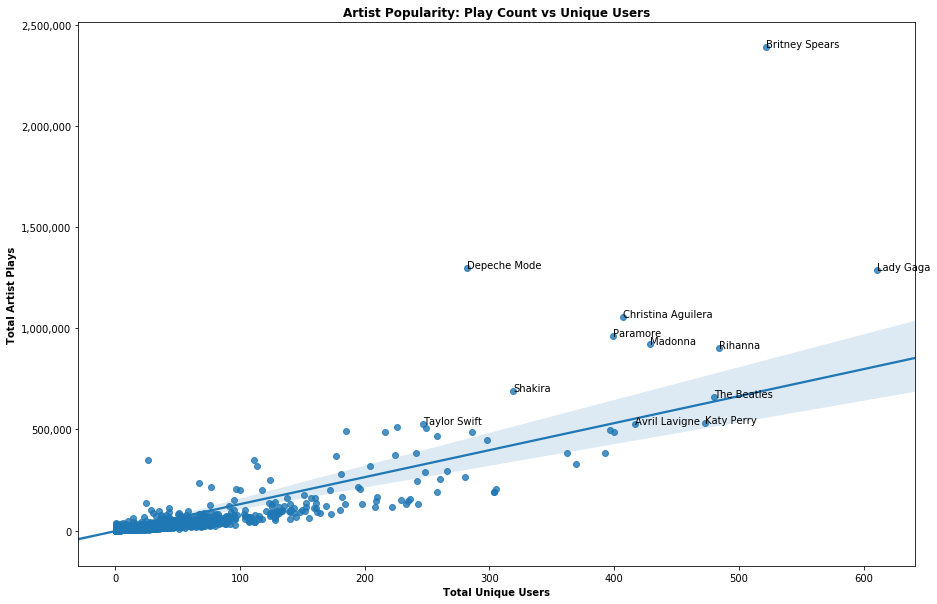

In [16]:
top_artists = artist_rank.sort_values(['totalArtistPlays'],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x,y)
ax.set_title('Artist Popularity: Play Count vs Unique Users',fontweight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users',fontweight='bold')
ax.set_ylabel('Total Artist Plays',fontweight='bold')

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

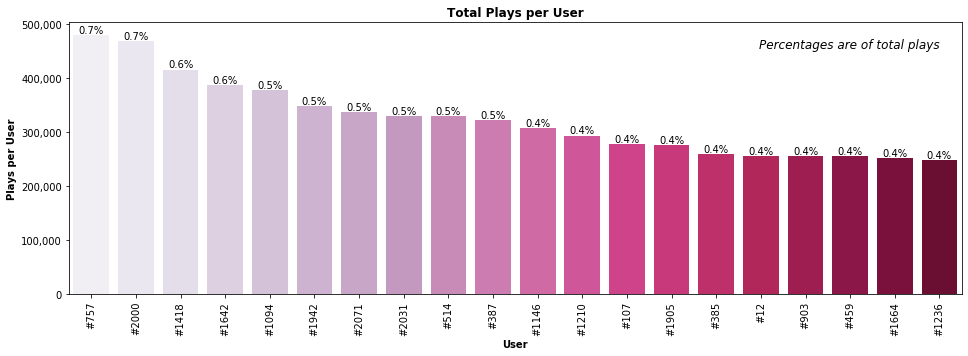

In [17]:
c3 = user_rank.sort_values(['totalUserPlays'],ascending=False)
c3['userID'] = c3.index
c3.userID = c3.userID.apply(lambda x: '#'+str(x))

x = c3.userID
y = c3.totalUserPlays
x_label = 'User'
y_label = 'Plays per User'
title = 'Total Plays per User'
caption = 'Percentages are of total plays'
total_val = ap3.userArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [18]:
artist_rank.sort_values(['avgUserPlays'],ascending=False).head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Viking Quest,1,35323,35323.00
Tyler Adam,1,30614,30614.00
Rytmus,1,23462,23462.00
Johnny Hallyday,2,32995,16497.50
Dicky Dixon,1,15345,15345.00


In [19]:
ap3[ap3['name']=='Viking Quest']

,id,name,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
80046,8388,Viking Quest,596,8388,35323,1,35323,35323.00,50,101469


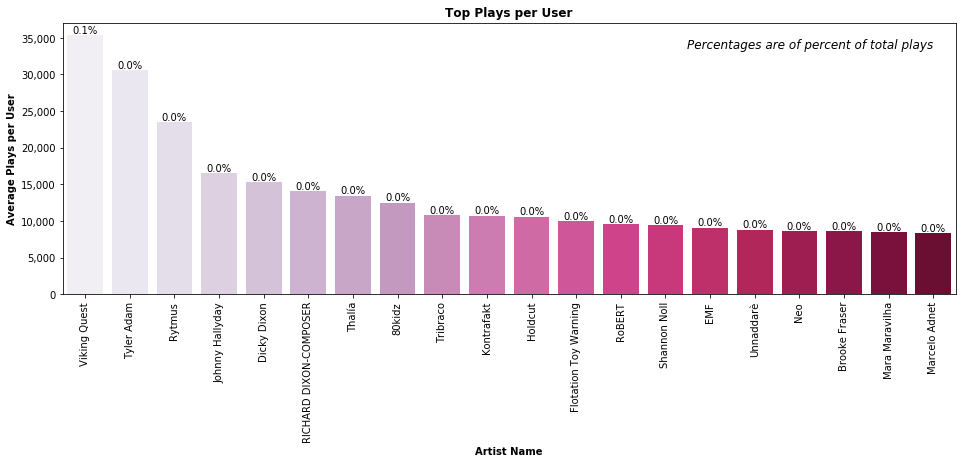

In [20]:
c4 = artist_rank.sort_values(['avgUserPlays'],ascending=False)

x = c4.index
y = c4.avgUserPlays
x_label = 'Artist Name'
y_label = 'Average Plays per User'
title = 'Top Plays per User'
caption = 'Percentages are of percent of total plays'
total_val = ap3.userArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

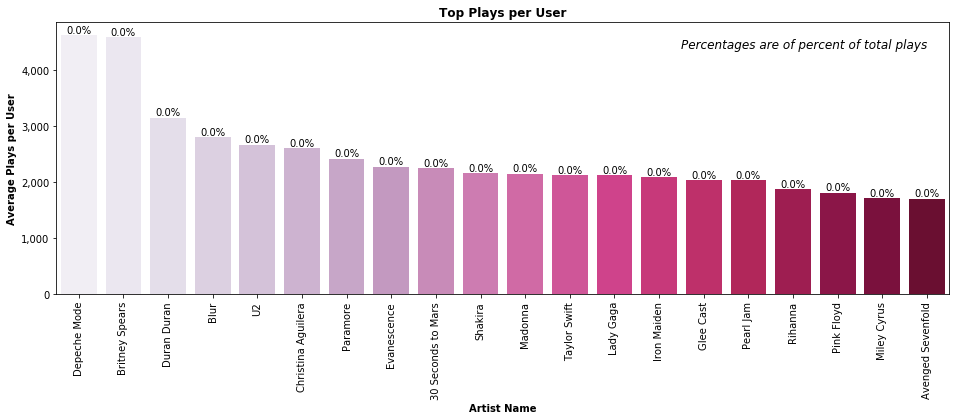

In [21]:
c5 = artist_rank[artist_rank['totalUniqueUsers']>100].sort_values(['avgUserPlays'],ascending=False)

x = c5.index
y = c5.avgUserPlays
x_label = 'Artist Name'
y_label = 'Average Plays per User'
title = 'Top Plays per User'
caption = 'Percentages are of percent of total plays'
total_val = ap3.userArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [22]:
# fit data into a sparse matrix of artist name (row) vs user (column)
# in terms of number of plays by artist/user
def data_to_sparse(data,index,columns,values):
    pivot = data.pivot(index=index,columns=columns,values=values).fillna(0)
    sparse = csr_matrix(pivot.values)
    print(sparse.shape)
    return pivot,sparse

# User K Nearest Neighbors to determine cosine distance amongst artists
def fit_knn(sparse):
    knn = NearestNeighbors(metric='cosine')
    knn.fit(sparse)
    print(knn)
    return knn

In [23]:
pivot_ap3,sparse_ap3 = data_to_sparse(ap3,index='name',columns='userID',values='userArtistPlays')

(17632, 1892)


In [24]:
knn = fit_knn(sparse_ap3)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [25]:
pivot_ap3.head()

userID,2,3,4,5,6,7,8,9,10,11,...,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
name,,,,,,,,,,,,,,,,,,,,,
!!!,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
!DISTAIN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
!deladap,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
#####,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
#2 Orchestra,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [26]:
def idx_recommend(data,idx,model,k):
    distances, indices = (model.kneighbors(data.
                                     iloc[idx,:].
                                     values.reshape(1,-1),
                                     n_neighbors=k+1))

    for i in range(0,len(distances.flatten())):
        if i == 0:
            print(('Recommendations for {}:\n'.
                  format(data.index[idx])))
        else:
            print(('{}: {} ({:.3f})'.
                  format(i,
                         data.index[indices.flatten()[i]],
                         distances.flatten()[i])))
    return ''

In [27]:
# we query a random artist
query_index = seed.choice(pivot_ap3.shape[0])
idx_recommend(pivot_ap3,query_index,knn,10)

Recommendations for VINILOVERSUS:

1: Don Davis (0.000)
2: Taking Back Sunday (0.792)
3: Ana Johnsson (0.856)
4: Lacuna Coil (0.864)
5: Breaking Benjamin (0.867)
6: Trapt (0.868)
7: Incubus (0.869)
8: Aerosmith (0.882)
9: Smile Empty Soul (0.895)
10: Paul Potts (0.910)


''

In [28]:
# lookup index number for select artists
query_index = pivot_ap3.index.get_loc('Katy Perry')
idx_recommend(pivot_ap3,query_index,knn,10)

Recommendations for Katy Perry:

1: The Matrix (0.409)
2: Henry Blank (0.414)
3: www.za4.bblog.mn (0.414)
4: Gratitude (0.414)
5: Kate Perry & Guru Josh Project (0.414)
6: MMLN (0.414)
7: Twitter: @BiruelBlogSU (0.414)
8: Hallway Blast (0.414)
9: GRAMMY (0.414)
10: DJplaceboing (0.414)


''

In [29]:
query_index = pivot_ap3.index.get_loc('Oasis')
idx_recommend(pivot_ap3,query_index,knn,10)

Recommendations for Oasis:

1: Fuel (0.349)
2: The Perishers (0.355)
3: Vertical Horizon (0.386)
4: The Wreckers (0.406)
5: The Vines (0.471)
6: Calogero (0.534)
7: Hednoize (0.534)
8: Grégory Lemarchal (0.570)
9: The Shins (0.598)
10: Matchbox Twenty (0.620)


''

In [30]:
# this will help us to locate partial matches of our query
def fuzzy_match(query_subject,data):
    ratio_tuples = []
    
    # each artist name is the subject in the data index
    # each artist in the data is compared against our query subject to determine percentage match
    # there may be ways to optimize this process by not looping through all artists
    for subject in data.index:
        ratio = fuzz.ratio(subject.lower(),query_subject.lower())
        current_query_idx = data.index.tolist().index(subject)
        ratio_tuples.append((subject, ratio,current_query_idx))
        
    # our findings are then sorted based on match rating, and top two are kept
    ratio_tuples = sorted(ratio_tuples, key=lambda tup: tup[1],reverse=True)[:2]
    
    print('Top matches: {}\n'.format([(x[0],x[1]) for x in ratio_tuples]))  
    
    match = ratio_tuples[0][0]
    
    return match, ratio_tuples

def artist_recommend(query_artist, data, model,k):
    
    # determine artist matches using fuzzy matching
    
    match, ratio_tuples = fuzzy_match(query_artist,data)
    
    # look up artist by query index
    idx_recommend(data, ratio_tuples[0][2],model,k)   
    return ''

In [31]:
artist_recommend('britney spears',pivot_ap3,knn,10)

Top matches: [('Britney Spears', 100), ('Britney Spears⊼', 97)]

Recommendations for Britney Spears:

1: Lindsay Lohan (0.504)
2: RuPaul (0.567)
3: Sarah Michelle Gellar (0.568)
4: mclusky (0.568)
5: Анастасия Приходько (0.568)
6: †‡† (0.570)
7: Nadia Oh (0.570)
8: Rachel Stevens (0.571)
9: L'Âme Immortelle (0.596)
10: Hilary Duff (0.622)


''

In [32]:
artist_recommend('nirvana',pivot_ap3,knn,10)

Top matches: [('Nirvana', 100), ('Nina', 73)]

Recommendations for Nirvana:

1: Nullset (0.130)
2: SoundGarden | www.CdsCompletos.net (0.130)
3: Humberto Gessinger Trio (0.130)
4: Green River (0.130)
5: Infectious Grooves (0.130)
6: 4 Non Blondes (0.135)
7: Puddle of Mudd (0.144)
8: Meat Puppets (0.152)
9: Institute (0.302)
10: Living Colour (0.309)


''

In [33]:
artist_recommend('red hot chillis',pivot_ap3,knn,10)

Top matches: [('Red Hot Chili Peppers', 78), ('The Chills', 64)]

Recommendations for Red Hot Chili Peppers:

1: The Offspring (0.568)
2: Kreator (0.630)
3: Bloodhound Gang (0.660)
4: 5'nizza (0.689)
5: Steppenwolf (0.691)
6: Beatallica (0.692)
7: Ногу Свело! (0.692)
8: Mercyful Fate (0.692)
9: John Frusciante (0.692)
10: Ленинград (0.692)


''

In [34]:
minPlaysPerUser = 1000 # minimum aggregate play count per user
minUniqueArtistPlays = 10 # minimum different artists that need values per user to be counted
minArtistPlays = 10000 # minimum times an artist must be played
minListeners = 10 # minimum unique listeners of artist to be played

def apply_threshold(data,
                    minPlaysPerUser,
                    minUniqueArtistPlays,
                    minArtistPlays,
                    minListeners):
    
    filtered = (data[(data['totalUserPlays']>=minPlaysPerUser) & 
               (data['totalUniqueArtists']>=minUniqueArtistPlays) & 
               (data['totalArtistPlays']>=minArtistPlays) & 
               (data['totalUniqueUsers']>=minListeners)])

    # confirm our min thresholds have been applied
    print('MINIMUM VALUES')
    print('totalUserPlays from {} to {}'.format(min(data.totalUserPlays),min(filtered.totalUserPlays)))
    print('totalUniqueArtists from {} to {}'.format(min(data.totalUniqueArtists),min(filtered.totalUniqueArtists)))
    print('totalArtistPlays from {} to {}'.format(min(data.totalArtistPlays),min(filtered.totalArtistPlays)))
    print('totalUniqueUsers from {} to {}'.format(min(data.totalUniqueUsers),min(filtered.totalUniqueUsers)))

    print('\nFILTER IMPACT')
    print("FILTERED Users: {} Artists: {}".format(len(filtered['userID'].unique()),
                                                           len(filtered['name'].unique())))
    print("ORIGINAL Users: {} Artists: {}".format(len(data['userID'].unique()),
                                                           len(data['name'].unique())))
    print("FILTERED % ORIGINAL Users: {:.1f}% Artists: {:.1f}%".format(100*(len(filtered['userID'].unique())/len(data['userID'].unique())),
                                                           100*(len(filtered['name'].unique())/len(data['name'].unique()))))
    return filtered

ap4 = apply_threshold(ap3,minPlaysPerUser,minUniqueArtistPlays,minArtistPlays,minListeners)

ap4[['totalUserPlays','totalUniqueArtists','totalArtistPlays','totalUniqueUsers']].describe()

MINIMUM VALUES
totalUserPlays from 3 to 1001
totalUniqueArtists from 1 to 10
totalArtistPlays from 1 to 10007
totalUniqueUsers from 1 to 10

FILTER IMPACT
FILTERED Users: 1790 Artists: 871
ORIGINAL Users: 1892 Artists: 17632
FILTERED % ORIGINAL Users: 94.6% Artists: 4.9%


,totalUserPlays,totalUniqueArtists,totalArtistPlays,totalUniqueUsers
count,52298.00,52298.00,52298.00,52298.00
mean,41467.40,49.87,192603.24,144.96
std,50438.77,1.70,336597.43,135.10
min,1001.00,10.00,10007.00,10.00
25%,13094.00,50.00,27175.00,45.00
50%,25511.00,50.00,64596.00,89.00
75%,48311.00,50.00,188634.00,208.00
max,480039.00,50.00,2393140.00,611.00


In [35]:
pivot_ap4,sparse_ap4 = data_to_sparse(ap4,index='name',columns='userID',values='userArtistPlays')
knn = fit_knn(sparse_ap4)

(871, 1790)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [36]:
artist_recommend('red hot chillis',pivot_ap4,knn,10)

Top matches: [('Red Hot Chili Peppers', 78), ('Hot Chip', 61)]

Recommendations for Red Hot Chili Peppers:

1: The Offspring (0.568)
2: Kreator (0.630)
3: John Frusciante (0.692)
4: Ennio Morricone (0.694)
5: In Extremo (0.696)
6: Riverside (0.697)
7: Katie Melua (0.701)
8: Ben Folds (0.702)
9: Bush (0.718)
10: Mylène Farmer (0.721)


''

In [37]:
ap4['userArtistPlays'].describe()

count    52298.00
mean       992.30
std       4885.03
min          1.00
25%        139.00
50%        323.00
75%        771.00
max     352698.00
Name: userArtistPlays, dtype: float64

In [38]:
# convert our play counts into ratings buckets
# a rating of 2 requires more than one play
# a rating of at least 1 is given for >=1 play (else 0)

b = ap4['userArtistPlays']
buckets = np.linspace(b.quantile(.005),b.quantile(.995),5)
print("Bucket thresholds: {}".format([int(b) for b in buckets]))
print("For instance, if value is {}, then the rank would be {}.".
      format(int(buckets[0]+1),len(buckets[:1])+1))

def bucketize(x):
    cur_bucket = 0
    for i in range(0,5):
        cur_bucket += 1
        if x <= buckets[i]:
            break
    return cur_bucket

Bucket thresholds: [6, 4621, 9237, 13853, 18469]
For instance, if value is 7, then the rank would be 2.


In [39]:
ap5 = ap4
ap5['rank'] = ap5['userArtistPlays'].apply(bucketize)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
ap5.groupby(['rank'])['userArtistPlays'].describe().T

rank,1,2,3,4,5
count,304.00,50493.00,872.00,254.00,375.00
mean,3.49,585.26,6230.25,11294.57,37443.69
std,1.73,737.34,1246.27,1272.97,42039.23
min,1.00,7.00,4627.00,9275.00,13860.00
25%,2.00,137.00,5186.00,10205.50,17133.50
50%,4.00,311.00,5889.50,11114.50,23830.00
75%,5.00,710.00,7138.75,12318.00,37931.50
max,6.00,4621.00,9199.00,13831.00,352698.00


In [41]:
pivot_ap5,sparse_ap5 = data_to_sparse(ap5,index='name',columns='userID',values='rank')
knn = fit_knn(sparse_ap5)

(871, 1790)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [42]:
artist_recommend('red hot chillis',pivot_ap5,knn,10)

Top matches: [('Red Hot Chili Peppers', 78), ('Hot Chip', 61)]

Recommendations for Red Hot Chili Peppers:

1: Nirvana (0.650)
2: Oasis (0.672)
3: Foo Fighters (0.685)
4: The Beatles (0.692)
5: Muse (0.706)
6: U2 (0.720)
7: Radiohead (0.721)
8: Aerosmith (0.722)
9: System of a Down (0.723)
10: Green Day (0.724)


''

In [43]:
ap6 = ap4
ap6['everPlayed'] = ap6['userArtistPlays'].apply(np.sign) # np.sign converts all positive values to one.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
pivot_ap6,sparse_ap6 = data_to_sparse(ap6,index='name',columns='userID',values='everPlayed')
knn = fit_knn(sparse_ap6)

(871, 1790)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [45]:
artist_recommend('red hot chillis',pivot_ap6,knn,10)

Top matches: [('Red Hot Chili Peppers', 78), ('Hot Chip', 61)]

Recommendations for Red Hot Chili Peppers:

1: Nirvana (0.649)
2: Oasis (0.677)
3: The Beatles (0.687)
4: Foo Fighters (0.688)
5: Muse (0.713)
6: Radiohead (0.717)
7: U2 (0.717)
8: Aerosmith (0.723)
9: Green Day (0.723)
10: System of a Down (0.726)


''

In [46]:
# lets try out some different artists
artist_list = [
               'Britney Spears',
               'Snoop Dogg',
               'Eminem',
               'Beatles',
               'D Bowie',
               'Tiesto',
               'Basshunter',
               'Akon',
               'Ace of Base',
               'Garth Brooks',
              ]

for artist in artist_list:
    print(artist_recommend(artist,pivot_ap6,knn,10))
    print('\n')

Top matches: [('Britney Spears', 100), ('Jordin Sparks', 67)]

Recommendations for Britney Spears:

1: Rihanna (0.168)
2: Christina Aguilera (0.213)
3: Lady Gaga (0.224)
4: Katy Perry (0.229)
5: Beyoncé (0.250)
6: Ke$ha (0.299)
7: Shakira (0.337)
8: Miley Cyrus (0.338)
9: Madonna (0.338)
10: Avril Lavigne (0.359)



Top matches: [('Snoop Dogg', 100), ('No Doubt', 56)]

Recommendations for Snoop Dogg:

1: Ice Cube (0.496)
2: 2Pac (0.522)
3: DMX (0.605)
4: D12 (0.655)
5: Nas (0.658)
6: Jay-Z (0.661)
7: Busta Rhymes (0.671)
8: Mobb Deep (0.697)
9: 50 Cent (0.701)
10: Cypress Hill (0.743)



Top matches: [('Eminem', 100), ('The Maine', 67)]

Recommendations for Eminem:

1: Ke$ha (0.630)
2: Rihanna (0.649)
3: Katy Perry (0.651)
4: B.o.B (0.667)
5: Britney Spears (0.669)
6: Lady Gaga (0.669)
7: Black Eyed Peas (0.674)
8: P!nk (0.684)
9: Miley Cyrus (0.686)
10: Christina Aguilera (0.695)



Top matches: [('The Beatles', 78), ('Beastie Boys', 63)]

Recommendations for The Beatles:

1: Radiohea

In [47]:
# convert our pandas dataframe into a turicreate SFrame
sf = tc.SFrame(ap6)

In [48]:
sf.head()

id,name,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays
72,Depeche Mode,1642,72,352698,282,1301308
792,Thalía,2071,792,324663,26,350035
511,U2,1094,511,320725,185,493024
203,Blur,1905,203,257978,114,318221
498,Paramore,1664,498,227829,399,963449
378,Evanescence,1146,378,203165,226,513476
292,Christina Aguilera,514,292,176133,407,1058405
701,Shakira,1983,701,172496,319,688529
701,Shakira,757,701,169596,319,688529
679,Glee Cast,1086,679,165902,249,506453


In [49]:
# split data into train and test sets
train, test = tc.recommender.util.random_split_by_user(sf,
                                                       user_id='userID',
                                                       item_id='name')

In [50]:
# we will test seven different model variations enabled with turicreate
def train_models(train_data, test_data,user_id,item_id,target):

    # popularity, no target
    m1 = tc.popularity_recommender.create(train_data,
                                          user_id=user_id,
                                          item_id=item_id,
                                          verbose=False
                                          )
    # similarity, no target
    m2 = tc.item_similarity_recommender.create(train_data,
                                               user_id=user_id,
                                               item_id=item_id,
                                               verbose=False,
                                               similarity_type='jaccard'
                                               )
    # ranking factorize, no target
    m3 = tc.ranking_factorization_recommender.create(train_data,
                                                     user_id=user_id,
                                                     item_id=item_id,
                                                     verbose=False
                                                     )
    # popularity with target
    m4 = tc.popularity_recommender.create(train_data,
                                          user_id=user_id,
                                          item_id=item_id,
                                          target=target,
                                          verbose=False
                                          )

    # ranking factorize with target
    m5 = tc.ranking_factorization_recommender.create(train_data,
                                                     user_id=user_id,
                                                     item_id=item_id,
                                                     target=target,
                                                     verbose=False
                                                     )
    # factorization with target
    m6 = tc.factorization_recommender.create(train_data,
                                             user_id=user_id,
                                             item_id=item_id,
                                             target=target,
                                             verbose=False
                                                       )
    # default with target
    m7 = tc.recommender.create(train_data,
                               user_id=user_id,
                               item_id=item_id,
                               target=target,
                               verbose=False      
                              )
    
    model_list = m1, m2, m3, m4, m5, m6, m7
    
    name_list = ['1. Popularity (Implicit, No Target)',
                 '2. Item Similarity (Implicit, No Target)',
                 '3. Ranking Factorization (Implicit, No Target)',
                 '4. Popularity (Explicit, With Target)',
                 '5. Ranking Factorization (Explicit, With Target)',
                 '6. Factorization (With Target)',
                 '7. Default (Explicit, With Target)']

    results = tc.recommender.util.compare_models(test_data,
                                                models=[m for m in model_list],
                                                model_names=[n for n in name_list],
                                                metric='auto')

    return model_list, name_list, results

In [51]:
# training our seven models with a binarized target (played or not played)
model_list, name_list, results = train_models(train, 
                                              test,
                                              user_id='userID',
                                              item_id='name',
                                              target='everPlayed')

Preparing data set.

Data has 46421 observations with 1789 users and 871 items.

Data prepared in: 0.106622s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46421 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.54545           | Not Viable                               |

| 1       | 1.13636           | Not Viable                               |

| 2       | 0.284091          | Not Viable                               |

| 3       | 0.0710227         | Not Viable                               |

| 4       | 0.0177557         | No Decrease (0.517547 >= 0.250138)       |

| 5       | 0.00443892        | 0.226643                                 |

| 6       | 0.00221946        | 0.234658                                 |

| 7       | 0.00110973        | 0.24598                                  |

| 8       | 0.000554865       | 0.244606                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00443892        | 0.226643                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 57us         | 0.250143          | 0.000954902           |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 205.635ms    | 0.265484          | 0.156669              | 0.00443892  |

| 2       | 378.759ms    | 0.220263          | 0.0976025             | 0.00443892  |

| 3       | 549.681ms    | 0.221636          | 0.118271              | 0.00443892  |

| 4       | 723.761ms    | 0.215222          | 0.112388              | 0.00443892  |

| 5       | 894.692ms    | 0.211969          | 0.112399              | 0.00443892  |

| 10      | 1.72s        | 0.208912          | 0.123369              | 0.00443892  |

| 25      | 4.18s        | 0.206441          | 0.141095              | 0.00443892  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.206307

Final training RMSE: 0.141199

PROGRESS: Evaluate model 1. Popularity (Implicit, No Target)

Precision and recall summary statistics by cutoff


/usr/local/lib/python3.6/dist-packages/turicreate/aggregate.py:92: UserWarning: Passing parameter(s) to COUNT is deprecated. This functionality will be removed in the next major release. Any passed parameters are ignored.
  + 'the next major release. Any passed parameters are ignored.')


+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.1062951496388029 | 0.014868510688944125 |
|   2    | 0.09907120743034056 |  0.028895233306998   |
|   3    | 0.10973512211902307 | 0.04975871508379249  |
|   4    | 0.09520123839009288 | 0.056363611162372804 |
|   5    | 0.08648090815273482 | 0.06435184182862198  |
|   6    | 0.07980736154110764 | 0.07124491435636948  |
|   7    | 0.07504054253280264 |  0.0783654340155888  |
|   8    | 0.07391640866873066 |  0.0869070500649448  |
|   9    | 0.07338607957803003 | 0.09609770747541645  |
|   10   | 0.07203302373581019 | 0.10548728017768264  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model 2. Item Similarity (Implicit, No Target)

Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_pr


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.12899896800825592 | 0.01881256571659047  |
|   2    | 0.09855521155830753 | 0.02975409809775134  |
|   3    | 0.08703130374957001 | 0.03912245019056167  |
|   4    | 0.09287925696594426 | 0.056575370507259096 |
|   5    | 0.08813209494324048 | 0.06666614259493515  |
|   6    | 0.08290333677330586 | 0.07415061145711299  |
|   7    |  0.0797582190771045 |  0.0824767080185037  |
|   8    | 0.07752837977296183 | 0.09159641814440579  |
|   9    | 0.07269808508198598 |  0.096878116150562   |
|   10   | 0.07038183694530444 | 0.10332725696502788  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model 4. Popularity (Explicit, With Target)

Precision and recall summary statistics by cutoff
+--------+------------------

In [52]:
# determine a user list for which to pull custom recommendations
top_users = user_rank.index[:5]
rand_users = seed.choice(sf['userID'],5)
user_list = list(top_users) + list(rand_users)
print("User list consists of:\nTop Users: {}\nRandom Users: {}".format(list(top_users),list(rand_users)))

User list consists of:
Top Users: [757, 2000, 1418, 1642, 1094]
Random Users: [527, 1170, 1798, 214, 2084]


In [53]:
def played_vs_rec(users,df,model_list,name_list,user_id,item_id,plays,target):
    assert len(model_list)==len(name_list)
    print("User List: {}\n".format(users))
    df = df[[user_id,item_id,plays,target]]
    for user in users:
        print('USER {}\n'.format(str(user)))
        print('***TOP PLAYS***')
        print(df[df[user_id]==user].sort(plays,ascending=False))
        print('\n')
        print('***RECOMMENDATIONS***')
        for i in range(len(model_list)):
            print('***{}***'.format(name_list[i]))
            results = model_list[i].recommend(users=[user],k=4)
            print(results)
        print('\n')

In [54]:
# although score improves, results seem to worsen when target is used in the model
played_vs_rec(user_list,
              sf,
              model_list,
              name_list,
              user_id='userID',
              item_id='name',
              plays='userArtistPlays',
              target='everPlayed')

User List: [757, 2000, 1418, 1642, 1094, 527, 1170, 1798, 214, 2084]

USER 757

***TOP PLAYS***
+--------+------------------+-----------------+------------+
| userID |       name       | userArtistPlays | everPlayed |
+--------+------------------+-----------------+------------+
|  757   |     Shakira      |      169596     |     1      |
|  757   |     Beyoncé      |      60877      |     1      |
|  757   |     Rihanna      |      31800      |     1      |
|  757   |  Britney Spears  |      30230      |     1      |
|  757   |      Eminem      |      26933      |     1      |
|  757   | Black Eyed Peas  |      26767      |     1      |
|  757   | Enrique Iglesias |      26723      |     1      |
|  757   | Michael Jackson  |      26148      |     1      |
|  757   |      Ke$ha       |      23277      |     1      |
|  757   |   Miley Cyrus    |      20003      |     1      |
+--------+------------------+-----------------+------------+
[41 rows x 4 columns]
Note: Only the head of the S

+--------+-----------------------+-----------------+------------+
| userID |          name         | userArtistPlays | everPlayed |
+--------+-----------------------+-----------------+------------+
|  1418  |       Lady Gaga       |      75414      |     1      |
|  1418  | The Devil Wears Prada |      39826      |     1      |
|  1418  |        Paramore       |      31834      |     1      |
|  1418  |       Hadouken!       |      30566      |     1      |
|  1418  |     Good Charlotte    |      28859      |     1      |
|  1418  |          Muse         |      27211      |     1      |
|  1418  |     Avril Lavigne     |      25575      |     1      |
|  1418  |     Enter Shikari     |      24663      |     1      |
|  1418  |      Linkin Park      |      18012      |     1      |
|  1418  |   Asking Alexandria   |      15147      |     1      |
+--------+-----------------------+-----------------+------------+
[28 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can 

+--------+--------------------------+-----------------+------------+
| userID |           name           | userArtistPlays | everPlayed |
+--------+--------------------------+-----------------+------------+
|  1170  |         Paramore         |       3899      |     1      |
|  1170  |      Arctic Monkeys      |       1270      |     1      |
|  1170  |     Yeah Yeah Yeahs      |       870       |     1      |
|  1170  |        The Kooks         |       828       |     1      |
|  1170  |        Cat Power         |       751       |     1      |
|  1170  | The All-American Rejects |       580       |     1      |
|  1170  |        Lily Allen        |       570       |     1      |
|  1170  |       The Beatles        |       452       |     1      |
|  1170  |       Maxïmo Park        |       426       |     1      |
|  1170  |    Cansei de Ser Sexy    |       403       |     1      |
+--------+--------------------------+-----------------+------------+
[36 rows x 4 columns]
Note: Only t

In [53]:
# Using the item similarity recommender, lets compare top plays with recommendations
# for our user list
played_vs_rec(user_list,
              sf,
              [model_list[1]],
              [name_list[1]],
              user_id='userID',
              item_id='name',
              plays='userArtistPlays',
              target='everPlayed')

NameError: name 'model_list' is not defined

In [58]:
artist_list

['Britney Spears',
 'Snoop Dogg',
 'Eminem',
 'Beatles',
 'D Bowie',
 'Tiesto',
 'Basshunter',
 'Akon',
 'Ace of Base',
 'Garth Brooks']

In [59]:
def find_similar(artist_list,model_list,data):
    for artist in artist_list:
        print(artist.upper())
        fuzz = process.extract(artist,data,limit=2) # applying fuzzy matching
        print(model_list[1].get_similar_items([fuzz[0][0]],k=5))     
    return ''

In [60]:
find_similar(artist_list,model_list,sf['name'])

BRITNEY SPEARS
+----------------+--------------------+--------------------+------+
|      name      |      similar       |       score        | rank |
+----------------+--------------------+--------------------+------+
| Britney Spears |      Rihanna       | 0.594936728477478  |  1   |
| Britney Spears | Christina Aguilera | 0.5689980983734131 |  2   |
| Britney Spears |     Katy Perry     | 0.5387324094772339 |  3   |
| Britney Spears |     Lady Gaga      | 0.538226306438446  |  4   |
| Britney Spears |      Beyoncé       | 0.5074626803398132 |  5   |
+----------------+--------------------+--------------------+------+
[5 rows x 4 columns]

SNOOP DOGG
+------------+--------------+---------------------+------+
|    name    |   similar    |        score        | rank |
+------------+--------------+---------------------+------+
| Snoop Dogg |     2Pac     |         0.25        |  1   |
| Snoop Dogg |     DMX      | 0.22727274894714355 |  2   |
| Snoop Dogg |   Ice Cube   | 0.2173913121223

''